<a href="https://colab.research.google.com/github/mbk-dev/okama/blob/master/examples/06%20backtesting%20distribution.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

In [ ]:
!pip install okama

In [1]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12.0, 6.0]

import okama as ok

Sometimes it could be usefull to check the properties of distribution for the asset returs and compare it with the normal distribution.  
**It is important to "backtest" the distribution before using different forecasting models.**

### Skewness

Skewness is a measure of symmetry.  
For normally distributed data, the skewness should be about zero.  
A skewness value greater than zero means that there is more weight in the right tail of the distribution.

**List of Assets**

Lets verify the skewnewss for a different types of assets:
- S&P 500 TR index
- US Real Estate ETF (VNQ)
- gold spot prices
- USD to EUR Exchange Rate

In [2]:
ls = ["SP500TR.INDX", "VNQ.US", "GC.COMM", "USDEUR.FX"]

In [3]:
al = ok.AssetList(
    ls, inflation=False
)  # iflation set to False as we don't need to compare the returns to indflation.
al

assets           [SP500TR.INDX, VNQ.US, GC.COMM, USDEUR.FX]
currency                                                USD
first_date                                          2004-10
last_date                                           2021-08
period_length                           16 years, 11 months
inflation                                              None
dtype: object

In [4]:
al.names

{'SP500TR.INDX': 'S&P 500 (TR)',
 'VNQ.US': 'Vanguard Real Estate Index Fund ETF Shares',
 'GC.COMM': 'Gold',
 'USDEUR.FX': 'USDEUR'}

Before we see the skewness of each asset we can visualize the distributions shapes with histograms. 

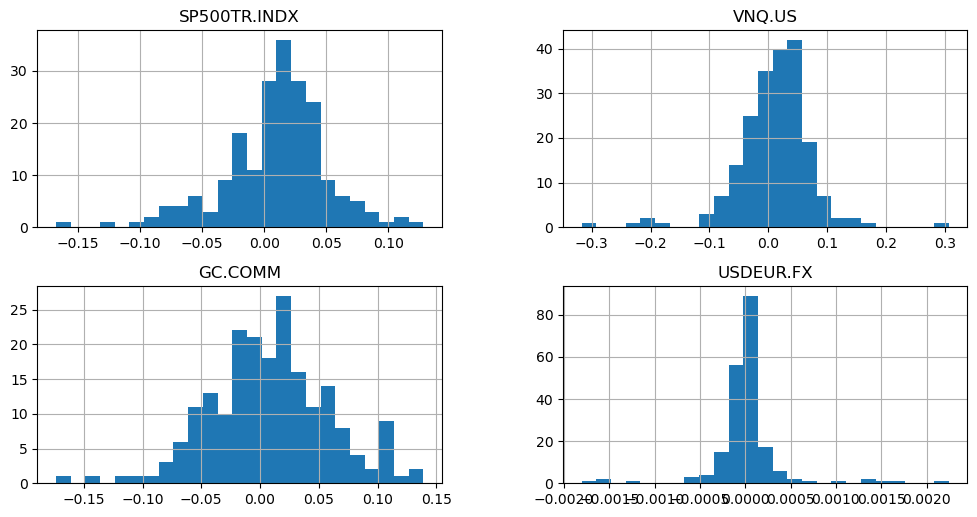

In [5]:
al.assets_ror.hist(bins=25);

Let's verify the expanding (accumulated) skewness.

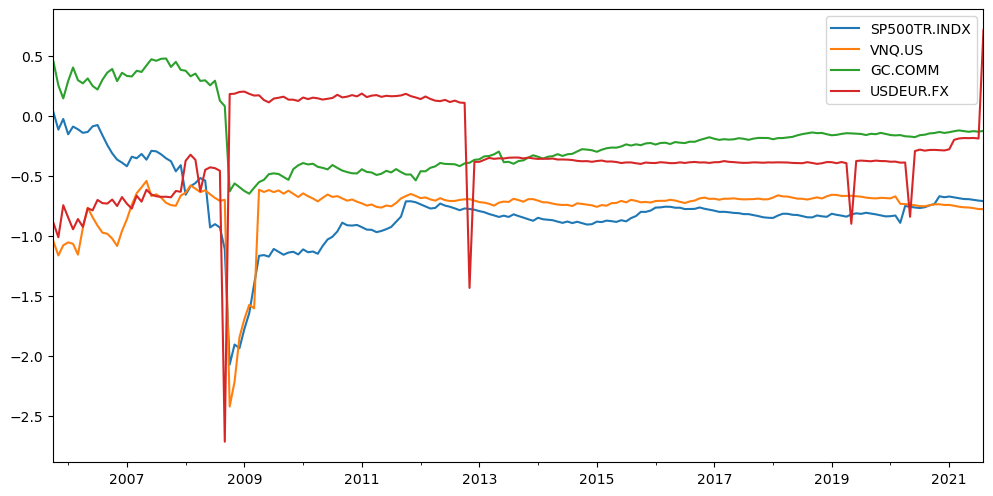

In [6]:
al.skewness.plot();

In the chart we can see that all the distributions have negative skewness. Only gold spot prices (GC.COMM) has the skewness close to zero.

In [7]:
al.skewness.iloc[-1]  # last values

SP500TR.INDX   -0.708473
VNQ.US         -0.775487
GC.COMM        -0.122514
USDEUR.FX       0.719562
Name: 2021-08, dtype: float64

We can also check the rolling skewness. It could be helpfull to verify how this parameter was changing over time.

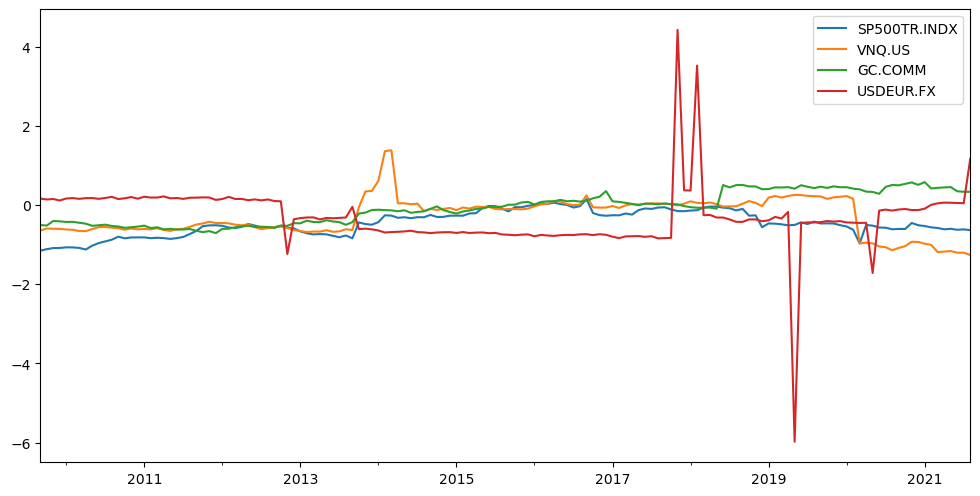

In [8]:
al.skewness_rolling(window=12 * 5).plot();

**Portfolio**

Skewness could be calculated also for portfolio returns time series.  
Let’s make a classic 60/40 stocks and bonds portfolio with Vanguard eldest index mutual funds.

In [9]:
weights = [0.6, 0.4]
funds = ["VFINX.US", "VBMFX.US"]

In [10]:
pf = ok.Portfolio(funds, weights=weights, inflation=False)
pf

symbol                   portfolio_7972.PF
assets                [VFINX.US, VBMFX.US]
weights                         [0.6, 0.4]
rebalancing_period                   month
currency                               USD
inflation                             None
first_date                         1987-09
last_date                          2021-08
period_length           34 years, 0 months
dtype: object

In [11]:
pf.names

{'VFINX.US': 'VANGUARD 500 INDEX FUND INVESTOR SHARES',
 'VBMFX.US': 'VANGUARD TOTAL BOND MARKET INDEX FUND INVESTOR SHARES'}

It's possible to visualize the historical distribution and verify how it fits the theoretical distribution.

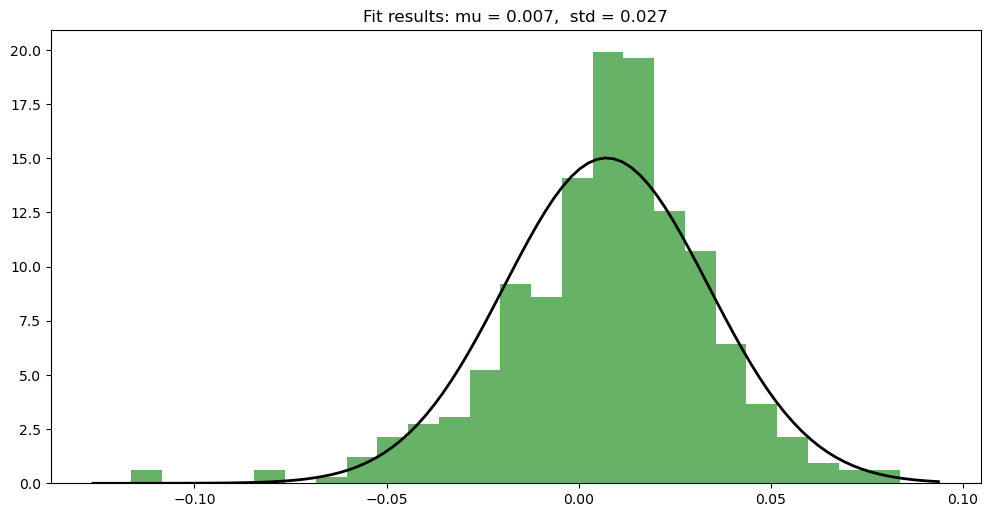

In [12]:
pf.plot_hist_fit(distr="norm", bins=25);

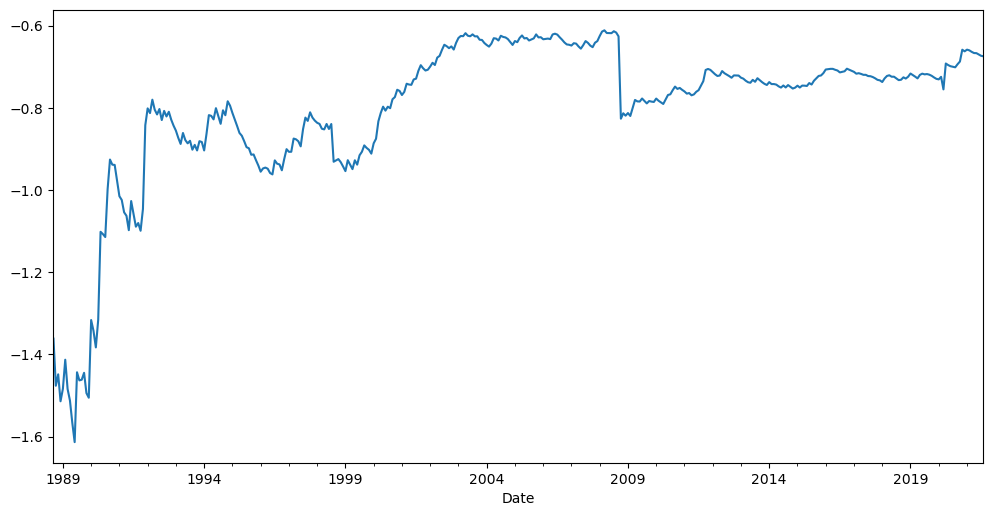

In [13]:
pf.skewness.plot();

It's interesting to see how the portfolio skewness gradually became slightly negative over time. Last skewness dradowns were in 2000 (dotcoms) and 2008 (global financial crisis).

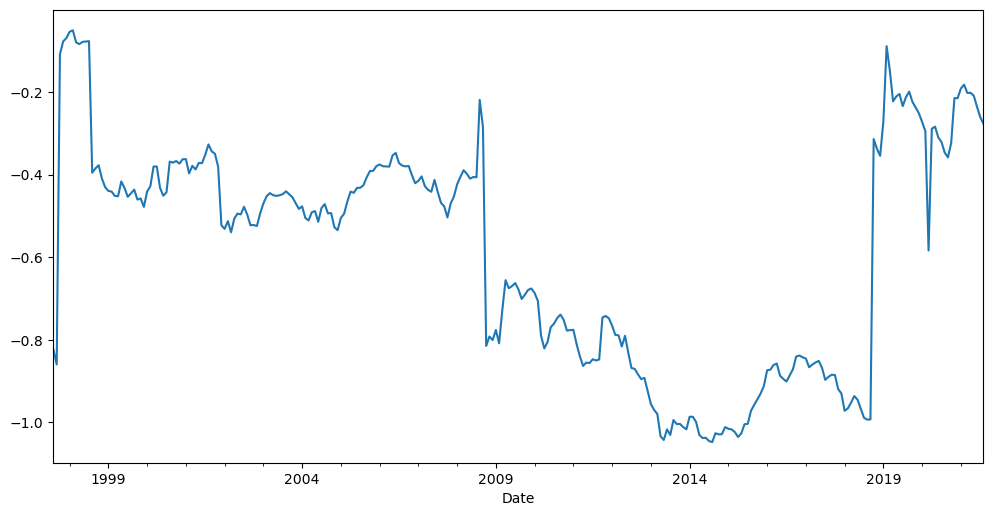

In [14]:
pf.skewness_rolling(window=12 * 10).plot();

However in rolling 10 year skewness chart we se how skewness increses in 2019.

### Kurtosis

Kurtosis is a measure of whether the data are heavy-tailed or light-tailed relative to a normal distribution.  
It should be close to zero for normal distribution (*okama* uses Fisher normalized kurtosis).  
The heavy (fat) tails mean that extreme events occur more frequently in reality than what a normal distribution would predict.

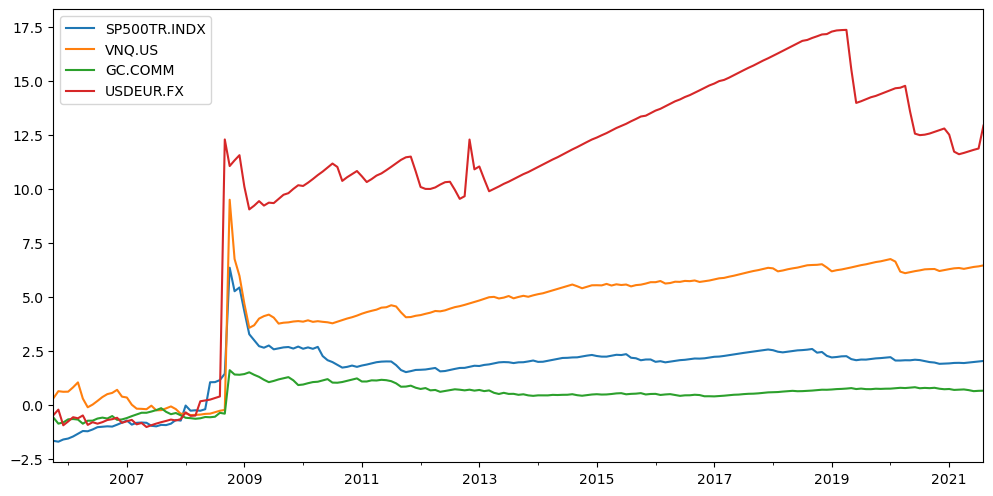

In [15]:
al.kurtosis.plot();

In [16]:
al.kurtosis.iloc[-1]  # last values

SP500TR.INDX     2.027928
VNQ.US           6.456612
GC.COMM          0.649624
USDEUR.FX       12.936975
Name: 2021-08, dtype: float64

We see here that gold spot prices returns are close to normal distribution. Also, S&P 500 returns have relatively low *kurtosis* when the rest of assets are clearly far from being normally distributed (especially USDEUR).

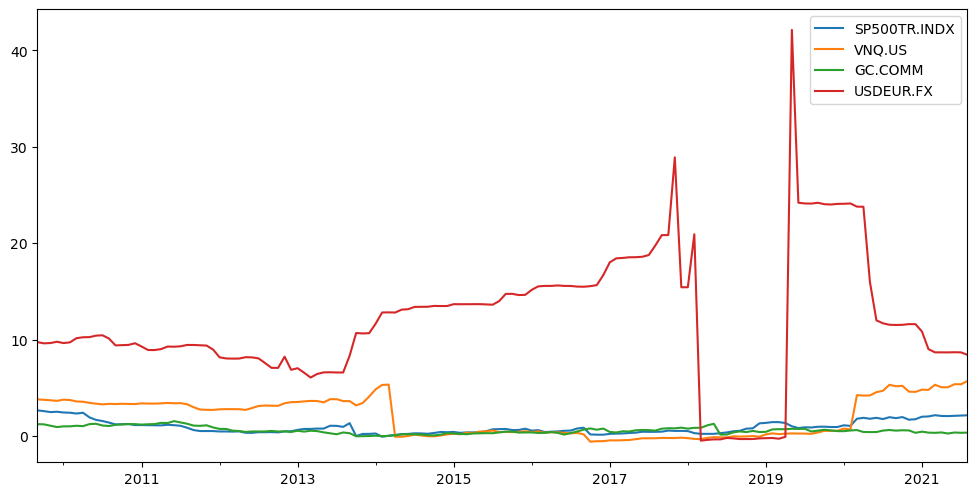

In [17]:
al.kurtosis_rolling(window=12 * 5).plot();

Rolling kurtosis with 4 years window confirms this conclusion.

It is interesting to verify *kurtosis* for the classic 60/40 portfolio.

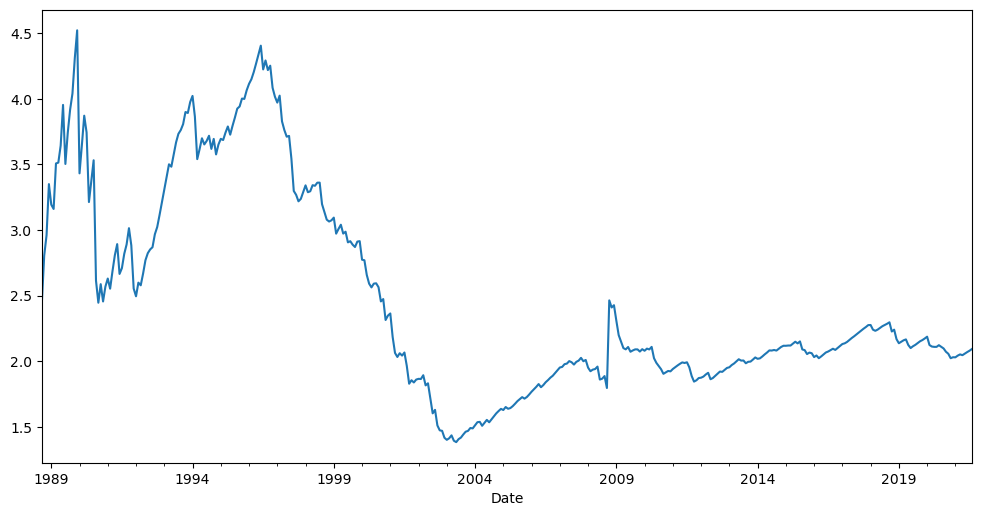

In [18]:
pf.kurtosis.plot();

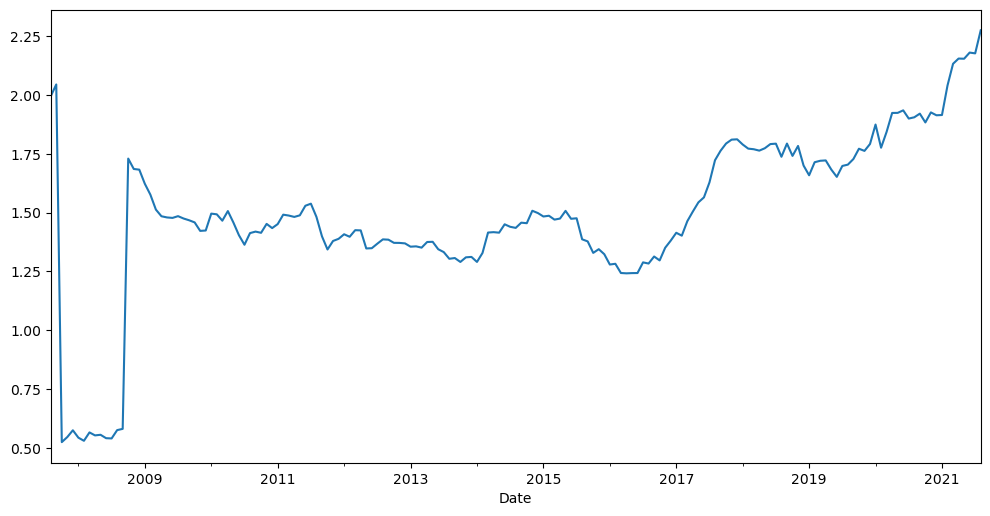

In [19]:
pf.kurtosis_rolling(12 * 20).plot();

In all charts we see that classic portfolio has kurtosis slightly different from zero.

### Jarque-Bera test for Normality

Jarque-Bera is a popular test for normality based on *skewness* and *kurtosis*.  
It shows whether the returns have the skewness and *kurtosis* matching a normal distribution (null hypothesis or H0).

Test returns *statistics* (first row) and  *p-value* (second row).  
*p-value* is the probability of obtaining test results, under the assumption that the null hypothesis is correct.  
In general, a large Jarque-Bera statistics and tiny **p-value** indicate that null hypothesis is rejected and the time series are not normally distributed.  

5% could be a good threshold for **p-value** to accepth the null hypothesis (H0).

In [20]:
al.jarque_bera

,SP500TR.INDX,VNQ.US,GC.COMM,USDEUR.FX
statistic,4.885843e+01,352.489969,3.589358,1358.209877
p-value,2.457690e-11,0.000000,0.166181,0.000000


In Jarque-Bera results for the list of assets we see that only gold (GC.COMM) distribution have small **p-values** (H0 is not rejected). 

In [21]:
pf.jarque_bera

{'statistic': 102.34639972867983, 'p-value': 0.0}

According to Jarque-Bera test the null hypotesis is rejected for the classic 60/40 portfolio. 

### Kolmogorov-Smirnov test

#### Normal distribution

In *okama* one sample Kolmogorov-Smirnov test is used for testing if a data follows a given distribution. We can check whether the returns time series are fitted good enough by normal or lognormal distributions.  

Like in Jarque-Bera test returns *statistic* (first row) and  *p-value* (second row).  Null hypotesis (two distributions are similar) is not rejected when *p-value* is high enough. 5% threshold can be used.

In [22]:
al.kstest(distr="norm")

,SP500TR.INDX,VNQ.US,GC.COMM,USDEUR.FX
statistic,0.106105,0.096820,0.037405,2.348557e-01
p-value,0.019156,0.041534,0.928662,2.480338e-10


H0 is not rejected for gold (GC.COMM) and Real Estate ETF (VNQ.US). Relatively close to 5% threshold is S&P 500.

In [23]:
pf.kstest(distr="norm")

{'statistic': 0.07633171601201894, 'p-value': 0.016312130796029008}

For 60/40 portfolio Kolmogorov-Smirnov test shows 6,5% p-value which is an aceptable value.

#### Lognormal distribution

Kolmogorov-Smirnov test could be used also to evaluate goodness of fit for **lognormal** distribution. 

In [24]:
al.kstest(distr="lognorm")

,SP500TR.INDX,VNQ.US,GC.COMM,USDEUR.FX
statistic,0.107048,0.09874,0.036502,2.328372e-01
p-value,0.017638,0.03560,0.940451,3.678075e-10


We see that p-value for gold (GC.COMM) is higher with lognormal distribution.

In [25]:
pf.kstest(distr="lognorm")

{'statistic': 0.07628264219237663, 'p-value': 0.01641287035011037}

According to Kolmogorov-Smirnov test 60/40 portfolio distribution is closer to normal.

### Q-Q or Quantile-Quantile Plot

Finally it's usefull to see how close are percentiles (quantiles) of historical data to theoretical distribution with **plot_percentiles_fit** (available for Portfolio).  

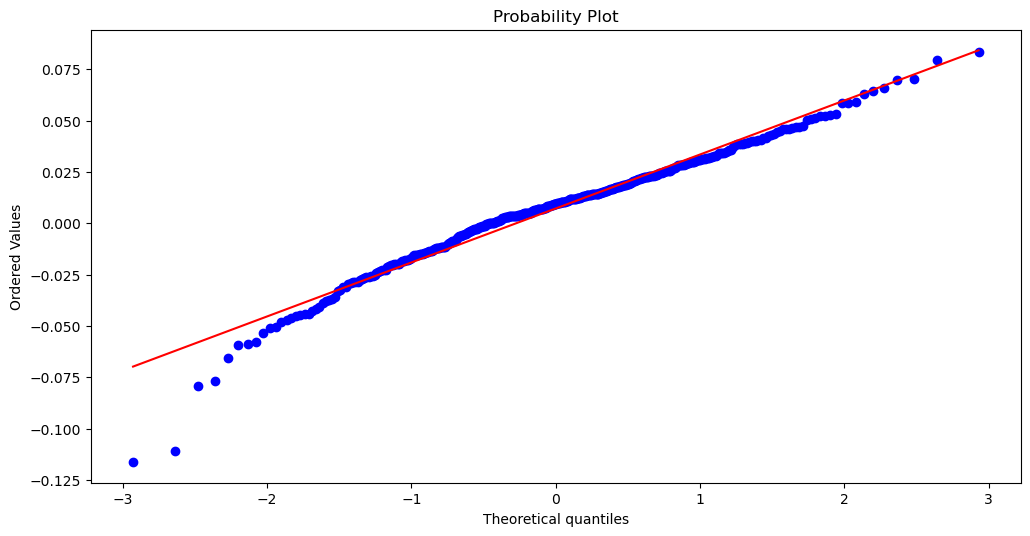

In [26]:
pf.plot_percentiles_fit(distr="norm")

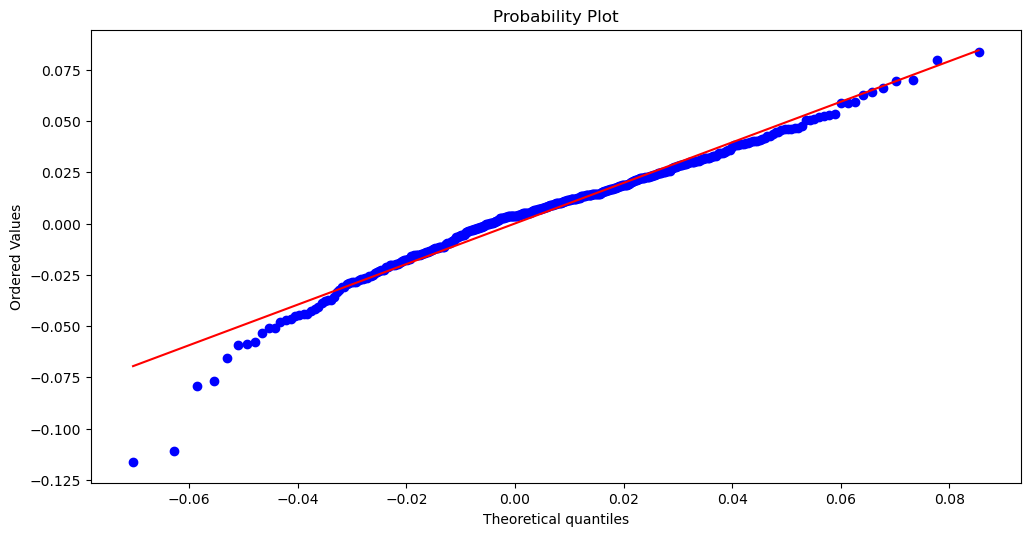

In [27]:
pf.plot_percentiles_fit(distr="lognorm")

Both lognormal and normal theoretical percentiles are deviate substantially at the low end (fat tails).